In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

% matplotlib inline
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from scipy.stats import skew
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

D:\Anaconda3\envs\py34\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 11

In [3]:
# The directory path
DIR = 'C:/Users/User/Desktop/Kaggle/Data/Sberbank Russian Housing Market/'
to_ensemble = 'C:/Users/User/Desktop/Kaggle/Data/Sberbank Russian Housing Market/to_ensemble/'

In [7]:
train = pd.read_csv(DIR + 'train_slow_models.csv')
test = pd.read_csv(DIR + 'test_slow_models.csv')
#macro = pd.read_csv(DIR + 'macro.csv')

In [9]:
train = train[['price_doc', 'full_sq', 'num_room', 'density']]
test = test[['full_sq', 'num_room', 'density']]

In [10]:
Y = train['price_doc']
del train['price_doc']

In [11]:
scaler = StandardScaler()
#scaler = RobustScaler()
scaler.fit(pd.concat([train, test], axis = 0))
train_cols = train.columns
train = pd.DataFrame(scaler.transform(train))
test = pd.DataFrame(scaler.transform(test))
train.columns, test.columns = train_cols, train_cols 

In [12]:
def rmsle(preds, Y):
    terms_to_sum = [(np.log(Y[i] + 1) - np.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(Y)]
    #return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5
    return (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

def rmsle_vector(preds, Y):
    terms_to_sum = [(np.log(Y[i] + 1) - np.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(Y)]
    #return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5
    return pd.Series(terms_to_sum, name = 'error')

In [13]:
def remove_outliers_for_linear():
#input your method here:
    new_tr = train
    new_te = test
    new_Y = Y
    bias = 25
    k = 0
    while bias > 5:
        a, b, c = evaluate_linear_regression(new_tr, new_te, new_Y)
        if k % 10 == 0:
            print('Step ' + str(k) + ' RMSLE: ' + str(np.round(c, 4)))
        new_tr['error'] = rmsle_vector(new_Y, a)
        bias = new_tr['error'].max()
        new_Y = (new_Y[new_tr['error'] < bias]).reset_index(drop = 1)
        new_tr = (new_tr[new_tr['error'] < bias]).reset_index(drop = 1)
        del new_tr['error']
        #print('Train shape: ' + str(new_tr.shape))
        k += 1
    print('Amount of deleted examples: ' + str(k))
    return new_tr, new_Y

111111112 100000 7128152.08389 6288681.0
4.4859708624803645


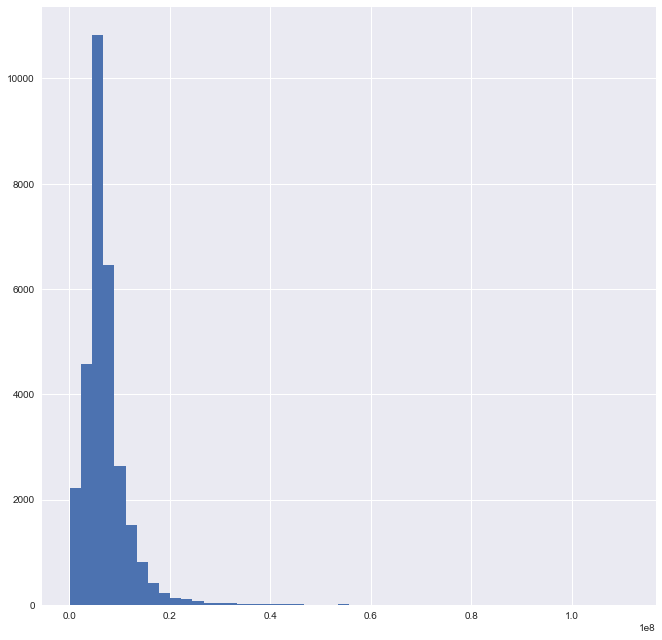

In [14]:
Y.hist(bins = 50)
print(Y.max(), Y.min(), Y.mean(), Y.median())
print(skew(Y))

95122496 395685 7158278.04902 6300000.0
4.285052808630463


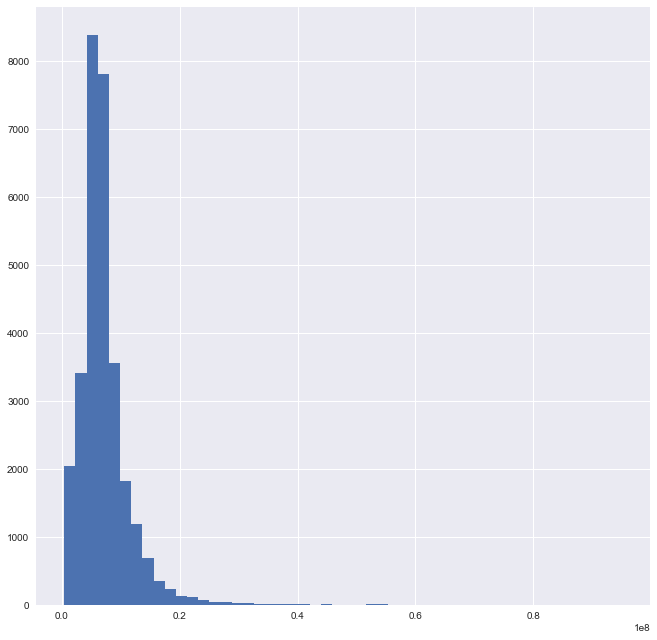

In [64]:
new_Y.hist(bins = 50)
print(new_Y.max(), new_Y.min(), new_Y.mean(), new_Y.median())
print(skew(new_Y))

In [24]:
new_tr, new_Y = remove_outliers_for_linear()

Step 0 RMSLE: 0.5308
Step 10 RMSLE: 0.5272
Step 20 RMSLE: 0.5241
Step 30 RMSLE: 0.5217
Step 40 RMSLE: 0.5195
Step 50 RMSLE: 0.5176
Step 60 RMSLE: 0.516
Step 70 RMSLE: 0.5143
Step 80 RMSLE: 0.5127
Step 90 RMSLE: 0.5113
Step 100 RMSLE: 0.5095
Step 110 RMSLE: 0.508
Step 120 RMSLE: 0.5066
Step 130 RMSLE: 0.5052
Step 140 RMSLE: 0.5038
Step 150 RMSLE: 0.502
Step 160 RMSLE: 0.5004
Step 170 RMSLE: 0.499
Step 180 RMSLE: 0.4976
Amount of deleted examples: 185


In [15]:
#Linear Regression Functions

def evaluate_linear_regression(train, test, Y):    
    #train, test - DataFrame; Y - Series
    
    model = LinearRegression()
    model_train_preds = np.zeros(train.shape[0])
    model_test_preds = np.zeros(test.shape[0])
     

    k = 0
    
    kf = KFold(n_splits = 7, random_state = 2016, shuffle = True)
    for train_index, test_index in kf.split(train, Y):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        Y_train = Y.iloc[train_index]
        
        model.fit(X_train, Y_train)
        
        model_train_preds[test_index] = model.predict(X_test)
        model_test_preds += model.predict(test)
    
        k += 1
    model_test_preds /= 7
    
    model_train_preds[model_train_preds < 0] = np.median(model_train_preds)
    model_test_preds[model_test_preds < 0] = np.median(model_test_preds)
    
    return (model_train_preds, model_test_preds, rmsle(Y, model_train_preds))
    
def clustering_for_linear(gamma, k):
    kmeans = KMeans(n_clusters = k, random_state = 2016)
    kmeans.fit(pd.concat([train, test], axis = 0))
    cluster_rbf_train = pd.DataFrame(np.exp((-1) * gamma * kmeans.transform(train)))
    cluster_rbf_test = pd.DataFrame(np.exp((-1) * gamma * kmeans.transform(test)))
    new_train = pd.concat([train, cluster_rbf_train], axis = 1)
    new_test = pd.concat([test, cluster_rbf_test], axis = 1)
    return new_train, new_test

def detect_rbf_clusters(gamma, k):
    k = int(k)
    new_train, new_test = clustering_for_linear(gamma, k)
    c = evaluate_linear_regression(new_train, new_test, Y)[-1]
    return (-1) * c

In [16]:
#KNN functions

def evaluate_knn_regressor(n, p, train, test, Y):    
    #train, test - DataFrame; Y - Series
    
    model = KNeighborsRegressor(n_neighbors = n, weights = 'distance', p = p,  n_jobs = 3)
    model_train_preds = np.zeros(train.shape[0])
    model_test_preds = np.zeros(test.shape[0])

    k = 0
    
    kf = KFold(n_splits = 7, random_state = 2016, shuffle = True)
    for train_index, test_index in kf.split(train, Y):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        Y_train = Y.iloc[train_index]
        
        model.fit(X_train, Y_train)
        
        model_train_preds[test_index] = model.predict(X_test)
        model_test_preds += model.predict(test)
        #print('Fold number: ' + str(k) + ' is ready', (k + 1) * '.')
        k += 1
    
    model_test_preds /= 7
    
    #Remove negative values
    model_train_preds[model_train_preds < 0] = np.median(model_train_preds)
    model_test_preds[model_test_preds < 0] = np.median(model_test_preds)
    
    return (model_train_preds, model_test_preds, rmsle(Y , model_train_preds))
    #return (model_train_preds, model_test_preds, mean_squared_error(Y , 1 + model_train_preds))
    
def optimize_knn(n, p):
    n = int(n)
    #return (-1) * evaluate_knn_regressor(n, p, new_tr, test, new_Y)[-1] #Вернуть!
    return (-1) * evaluate_knn_regressor(n, p, train, test, Y)[-1]

def detect_rbf_clusters_knn(gamma, k, n, p):
    k = int(k)
    n = int(n)
    new_train, new_test = clustering_for_linear(gamma, k)
    c = evaluate_knn_regressor(n, p, new_train, new_test, Y)[-1]
    return (-1) * c

In [17]:
#DecisionTreeRegression

def evaluate_dt_regressor(mss, msl, mwfl, mln, train, test, Y):    
    #train, test - DataFrame; Y - Series
    
    model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best',
                                  min_samples_split = mss, min_samples_leaf = msl,
                                 min_weight_fraction_leaf = mwfl, random_state = 2016, max_leaf_nodes = mln)
    model_train_preds = np.zeros(train.shape[0])
    model_test_preds = np.zeros(test.shape[0])
     

    k = 0
    
    kf = KFold(n_splits = 7, random_state = 2016, shuffle = True)
    for train_index, test_index in kf.split(train, Y):
        train['target'] = Y
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        Y_train = Y.iloc[train_index]
        
        kf_inn = KFold(n_splits = 7, random_state = 2017, shuffle = True)
        
        median_values = X_train.groupby('density').median()['target']
        X_test['density_mean_target'] = X_test['density'].apply(lambda x: median_values[x] if (x in median_values.index) == True else X_train['target'].median())
        X_train['density_mean_target'] = 0
        
        test['density_mean_target'] = test['density'].apply(lambda x: median_values[x] if (x in median_values.index) == True else X_train['target'].median())
        
        for sub_train_index, sub_test_index in kf_inn.split(X_train, Y_train):
            X, Xoof = X_train.iloc[sub_train_index], X_train.iloc[sub_test_index]
            median_values = X.groupby('density').median()['target']
            Xoof['density_mean_target'] = Xoof['density'].apply(lambda x: median_values[x] if (x in median_values.index) == True else X['target'].median())
            
            X_train.iloc[sub_test_index] = Xoof
            
        del X_train['target'], X_test['target'], train['target']
        
        model.fit(X_train, Y_train)
        
        model_train_preds[test_index] = model.predict(X_test)
        model_test_preds += model.predict(test)
    
        k += 1
        
    #delete for clustering
    del test['density_mean_target']
    model_test_preds /= 7
    
    #Remove negative values
    model_train_preds[model_train_preds < 0] = np.median(model_train_preds)
    model_test_preds[model_test_preds < 0] = np.median(model_test_preds)
    
    return (model_train_preds, model_test_preds, rmsle(Y, model_train_preds))

def optimize_dt(mss, msl, mwfl, mln):
    mss = int(mss)
    msl = int(msl)
    mln = int(mln)
    #return (-1) * evaluate_dt_regressor(mss, msl, mwfl, mln, new_tr, test, new_Y)[-1]   #Вернуть!
    return (-1) * evaluate_dt_regressor(mss, msl, mwfl, mln, new_tr, test, new_Y)[-1]   

In [26]:
a, b, c = evaluate_linear_regression(new_tr, test, new_Y)
print('7fold-CV RMSLE: ' + str(c))

7fold-CV RMSLE: 0.49675094933


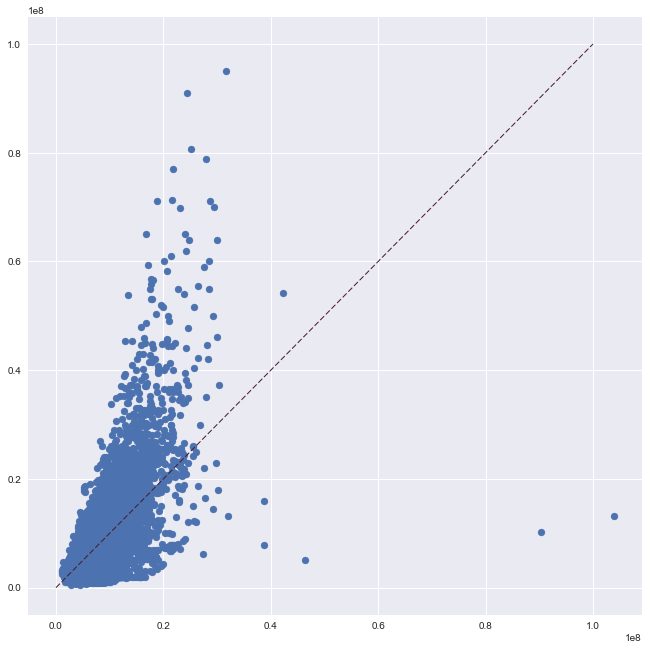

In [28]:
plt.scatter(a, new_Y)
plt.plot([0, 1e8], [0, 1e8], 'k--', lw = 1, c = '#4a192c')
plt.show()

In [29]:
a, b, c = evaluate_knn_regressor(153, 1.0291, new_tr, test, new_Y) #вообще хорошие параметры!
print('7fold-CV RMSLE: ' + str(c))

7fold-CV RMSLE: 0.492138088839


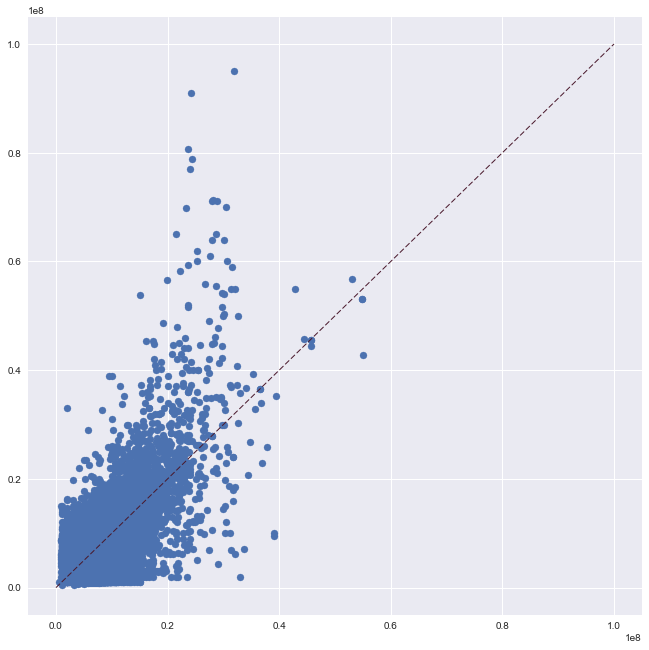

In [31]:
plt.scatter(a, new_Y)
plt.plot([0, 1e8], [0, 1e8], 'k--', lw = 1, c = '#4a192c')
plt.show()

In [35]:
a, b, c = evaluate_dt_regressor(260, 16, 0.1171, 51, new_tr, test, new_Y)
print('7fold-CV RMSLE: ' + str(c))

7fold-CV RMSLE: 0.461543241667


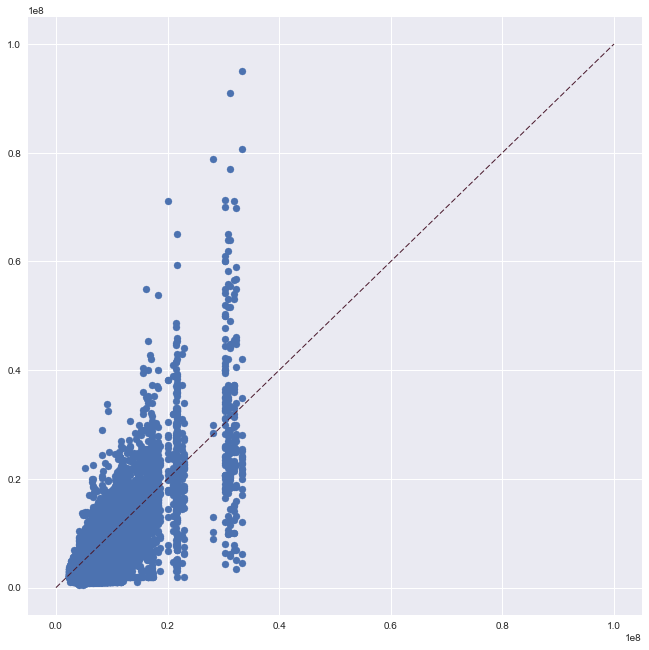

In [37]:
plt.scatter(a, new_Y)
plt.plot([0, 1e8], [0, 1e8], 'k--', lw = 1, c = '#4a192c')
plt.show()

In [34]:
dtBO = BayesianOptimization(optimize_dt, {'mss' : (2, 1000), 'msl' : (2, 1000), 'mln' : (2, 500), 'mwfl' : (0.01, 0.49)})
dtBO.maximize(init_points = 5, n_iter = 25)

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |       mln |       msl |       mss |      mwfl | 
    1 | 00m19s |   -0.47522 |   83.9123 |  947.0786 |  250.0595 |    0.1959 | 
    2 | 00m18s |   -0.46030 |  379.2941 |  205.2168 |  133.3756 |    0.3262 | 
    3 | 00m18s |   -0.47287 |  309.6992 |  686.5942 |  335.0623 |    0.4573 | 
    4 | 00m18s |   -0.46655 |  120.3290 |  501.2347 |  518.6078 |    0.3927 | 
    5 | 00m18s |   -0.46559 |   54.6592 |  422.9962 |  109.3313 |    0.4407 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |       mln |       msl |       mss |      mwfl | 
    6 | 00m23s |   -0.47489 |   15.3725 |   25.5992 |  898.7659 |    0.3023 | 
    7 | 00m20s |   -0.45690 |  260.8606 |   16.6595 |   51.5001 |    0.1171 | 
    8 | 00m20s |   -0.45705 |  229.1085 |   12.5174 |  235.1041 |    0.3247 | 
    9 | 00m19s | 

In [ ]:
рекорд: 0.48871 ---> 0.45654

In [96]:
knnBO = BayesianOptimization(optimize_knn, {'n' : (2, 500), 'p' : (1, 2)})
knnBO.maximize(init_points = 5, n_iter = 5)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         n |         p | 
    1 | 01m52s |   -0.48757 |  207.1540 |    1.0418 | 
    2 | 01m42s |   -0.49270 |  346.9319 |    1.8341 | 
    3 | 01m53s |   -0.49027 |  316.2893 |    1.2871 | 
    4 | 02m00s |   -0.48960 |  309.2730 |    1.1530 | 


KeyboardInterrupt: 

In [51]:
clusterBO = BayesianOptimization(detect_rbf_clusters, {'gamma' : (0, 1), 'k' : (2, 100)})
clusterBO.maximize(init_points = 7, n_iter = 7)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |     gamma |         k | 


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
'''' рекорд качества:
в KNN хорошо хаходит sport_count_5000, sport_count_3000
KNN: 0.491257, n = 153, p = 1.0291, 'life_sq', 'full_sq', 'kitch_sq', 'num_room', 'density', 'area_m', 'raion_popul'
LR: 0.49131, gamma = 0.1750, k = 73, 'life_sq', 'full_sq', 'kitch_sq', 'num_room', 'density', 'area_m', 'children_preschool', 'poselenie_in_sub_area',
'sport_count_5000', 'sport_count_3000', trc_count_5000 + density_mean_target

''''